Simple Springs
====

Coding
----
The programming in this chapter is relatively simple - it's intended to be an introduction into how to write fairly readable and expressive code, while staying reasonably close to what you might encounter in the wild.

I've broadly followed a few basic principles that I think students could benefit from:
 * If you find yourself writing the same lines of code multiple times, put it in a function
 * Use expressive variable names: `times` is better than `t`; `positions` is better than `x`
 * Try to use whitespace to make your code more readable
 * No "magic numbers"- instead of
 
    `times = np.linspace(0, 1, 50)`
 
 try:
 
     ```min_time, max_time = 0, 1
     n_timesteps = 50
     times = np.linspace(min_time, max_time, n_timesteps)
     ```
 
 
 * Comments should explain *why* your code is there- not *how* it works. (The code itself tells you *how*.)
   Consider:
   
    `x = 0  # Set x to 0`
 
     vs.
 
    `x = 0  # Reset x to its initial value before each calculation - otherwise our sum doesn't converge`


Physics
----
We'll start with one mass on a spring.

Here it is:

![Single Mass](img/one_mass.png)

### Analytical Solution

The equation governing its motion is:

$m\ddot x = -k x$

Which we will rewrite as:

$\ddot x + \omega_0 ^2 x = 0$; $\omega_0^2 = \frac{k}{m}$.

You probably already know the solution to this; depending on the initial conditions, $x(t)$ will look like:

$x = Acos(\omega_0 t) + Bsin(\omega_0 t)$

For example if the spring starts at $x=1$ and $\dot x =0$, the solution is
$x = cos(\omega_0 t)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define some constants
m = 1.0
k = 1.0

omega = np.sqrt(k / m)

initial_position = 1.0
initial_vely = 0.0

# We'll also need to define some time steps at which to evaluate the motion
min_time, max_time = 0.0, 4 * np.pi
n_timesteps = 100
times = np.linspace(min_time, max_time, n_timesteps)

# We already know the analytical solution (it's in the cell above)
def analytical_solution(t):
    """
    t can be a single value or an iterable
    
    """
    return np.cos(omega * t)


analytical_positions = analytical_solution(times)

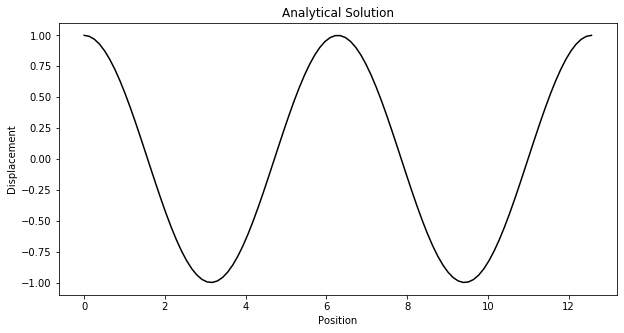

In [2]:
# I always like to put plotting code in a separate cell to calculations, so I can easily tweak the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(times, analytical_positions, "k-")
ax.set_title("Analytical Solution")
ax.set_xlabel("Position")
ax.set_ylabel("Displacement")

plt.show()

###  Numerical Solution

We can also solve this equation numerically using scipy's `solve_ivp` function. (You can find this out by e.g. googling "python solve differential equation").

To do this, we need to rewrite our second-order differential equation as two first-order differential equations (this is always possible - make a new variable $v = \dot x$...).
We will arrive at two equations of the form $\dot x = v$; $\dot v = f(t, x)$:

$\dot x = v$  
$\dot v = - \omega_0^2 x$

Once we have done this, we don't need to think any more - `scipy` will solve the equations for us. We just need to provide the intial conditions and domain we're interested in, someone else's code will do the rest:

In [3]:
from scipy.integrate import solve_ivp

# We need to define a function that describes our system of first-order equations
# What this requires is described in the documentation, but basically we just need a function
# that takes a time (t) and a list of parameters (params), and returns an iterable (e.g. a list) of the right hand sides


def rhs(t, params):
    """
    The right hand sides of the above coupled first-order differential equations.
    
    :param t: time
    :param params: iterable of (position, velocity)
    
    """
    # params are [x, v]; we want to return [v, -omega^2 * x]
    return (params[1], -omega * omega * params[0])


# solve_ivp returns an object containing lots of interesting information, detailed in the documentation
solution = solve_ivp(rhs, [min_time, max_time], (1.0, 0.0), t_eval=times)

# For now we're only interested in the solution ("y")- specifially, the 0th element (positions)
numerical_solution = solution.y[0]

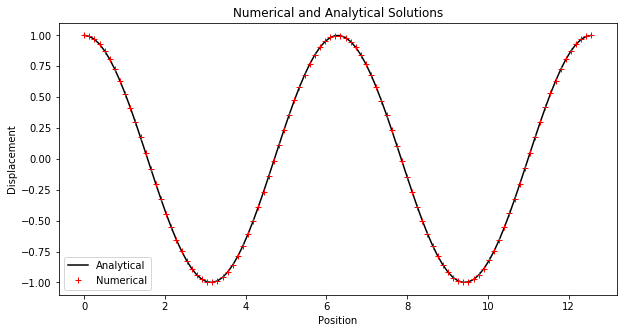

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(times, analytical_positions, "k-", label="Analytical")
ax.plot(times, numerical_solution, "r+", label="Numerical")

ax.legend()
ax.set_title("Numerical and Analytical Solutions")
ax.set_xlabel("Position")
ax.set_ylabel("Displacement")

plt.show()

The analytical and numerical solutions match up almost exactly- which is what we'd hope for.

### Animations


A static line graph is the best way to represent the relationship between two variables for a lecture handout/paper/lab report - but this isn't what a modern physicist/data scientist/student wants to do when they first get their hands on some data.

The first thing we want to do is to get to grips with the data. For example, we may look through a spreadsheet of raw data, make many plots of many variables or make some animations.

Animations are also very good for presentations - they can make your slides more interesting - I'll go through a simple example here using `matplotlib`. More complete examples are available in the `matplotlib` documentation.

<IPython.core.display.Javascript object>


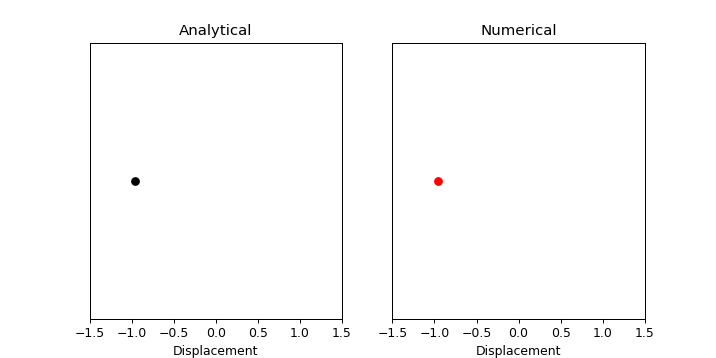

In [5]:
from matplotlib.animation import FuncAnimation

# Magic command that we need to put in so that animations work
%matplotlib notebook

# Create a figure containing two axes to show our numerical + analytical solutions side-by-side
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Some plot settings
titles = "Analytical", "Numerical"
for a, t in zip(ax, titles):
    a.set_xlabel("Displacement")
    a.set_yticks([])
    a.set_title(t)
    a.set_xlim(-1.5, 1.5)
    a.set_ylim(-1, 1)

# Create line objects that we will use to draw the masses (they're empty for now)
analytical_line, = ax[0].plot([], [], "ko")
numerical_line, = ax[1].plot([], [], "ro")

# Function to intialise each plot; basically just plot the blank background
def init():
    analytical_line.set_data([], [])
    numerical_line.set_data([], [])
    return analytical_line, numerical_line


# The animation function.
# This is called in a loop- we pass it the frame number (i) and draw our masses positions at time times[i].
# i.e. for the i'th frame, we draw a point at (analytical_positions[i], 0)
def animate(i):
    analytical_line.set_data(analytical_positions[i], 0)
    numerical_line.set_data(numerical_solution[i], 0)
    return analytical_line, numerical_line


# Now we are ready to create our Animation object- this is the easiest way to make animations in matplotlib
# The blit keyword tells matplotlib to only update the parts of the plot which change between frames
anim = FuncAnimation(
    fig, animate, init_func=init, frames=n_timesteps, interval=20, blit=True
)

Aside: `matplotlib.animate` can be very fiddly to work with. You can get cryptic error messages or (even worse) not see the error message at all, and just be left with a blank figure. Don't worry if your animation doesn't work straight away - try following the tips on [link] if you're having issues.